In [730]:
%reset -f
%load_ext autoreload
%autoreload 2

import numpy as np
from scipy.stats import gamma
from scipy import integrate
from scipy.misc import derivative
import matplotlib.pyplot as plt
import math
from numba import njit

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [731]:
def gamma_mean(shape, scale):
    return gamma.mean(shape, scale=scale)

In [732]:
shape = 4
scale = 1

op1 = {
    "start": 0,
    "min_time": 5,
    "shape": shape,
    "scale": scale,
}
op1["mean_time"] = gamma_mean(op1["shape"], op1["scale"]) + op1["min_time"]
op1

{'start': 0, 'min_time': 5, 'shape': 4, 'scale': 1, 'mean_time': 9.0}

In [733]:
op2_start = 10

<h1>Method A</h2>

In [734]:
critical_x = op2_start - op1["start"] - op1["min_time"]
critical_x

5

In [735]:
p = gamma.sf(critical_x, op1["shape"], scale=op1["scale"])
p

0.2650259152973615

In [736]:
worst_case_x = op1["start"] + op1["min_time"] + op1["shape"] * 2 * op1["scale"]
worst_case_x

13

In [737]:

@njit(nogil=True, fastmath=True, cache=True)
def f(x, shape, scale, p):
    rate = 1 / scale 
    e = np.exp(-rate*x)
    y = (rate ** shape / math.gamma(shape)) * x ** (shape-1) * e
    y = y * x / p
    return y

step = 0.04  # adjust this based on the required precision
x_values = np.arange(critical_x, worst_case_x, step)
y_values = f(x_values, op1["shape"], op1["scale"], p)

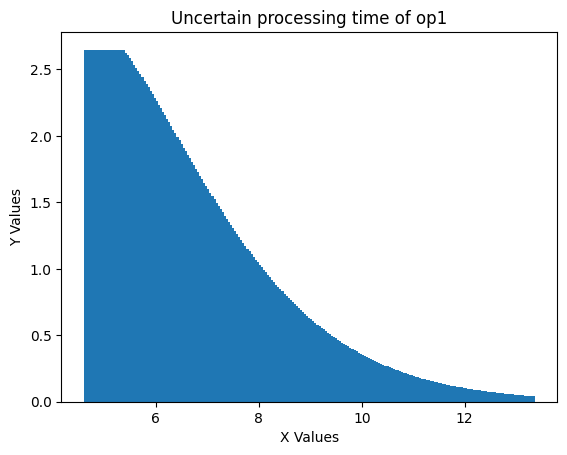

In [738]:
plt.bar(x_values, y_values)
plt.xlabel('X Values')
plt.ylabel('Y Values')
plt.title('Uncertain processing time of op1')
plt.show()

In [739]:
overlap = np.trapz(y_values, x_values) - critical_x # -critical neccessary?
overlap

1.590275137425019

In [740]:
overlap = overlap * p
overlap

0.42146412387070303

<h1>Method B</h1>

In [741]:
print(f"worst case: {worst_case_x}")
print(f"critical: {critical_x}")
print(f"p: {p}")

worst case: 13
critical: 5
p: 0.2650259152973615


In [742]:
def pdf_ableitung(x, shape, scale):
    return gamma.pdf(x, shape, scale=scale) * x #(shape / x - scale)

def pdf_ableitung2(x, shape, scale): # händisch
    rate = 1 / scale
    abl = rate**shape * x**(shape-2) * (rate*x - shape + 1) * np.exp(-rate*x)
    abl = abl / math.gamma(shape)
    return abl

def pdf_ableitung3(x, shape, scale): # scipy (gleiches ergebnis wie händisch)
    return derivative(lambda x: gamma.pdf(x, shape, scale=scale), x, dx=1e-6)

def f(x):
    return pdf_ableitung2(x, shape, scale) / p

In [743]:
integral, error = integrate.quad(f, critical_x, worst_case_x)# - critical_x
integral

0.5265380873156706

In [744]:
f0 = p * (integral - critical_x)
f0

-1.18558333795705

<h1>More tests</h1>

In [745]:
test, _ = integrate.quad(lambda x: gamma.pdf(x, shape, scale=scale), critical_x, worst_case_x)
test # same as 1-cdf(critical_x)

0.2639756155662512

In [746]:
test2, _ = integrate.quad(lambda x: gamma.pdf(x, shape, scale=scale) * x / p, critical_x, worst_case_x)
test2

6.591854968890291

In [747]:
foo = gamma.cdf(test2-critical_x, shape, scale=scale)
foo

0.07769487909221486

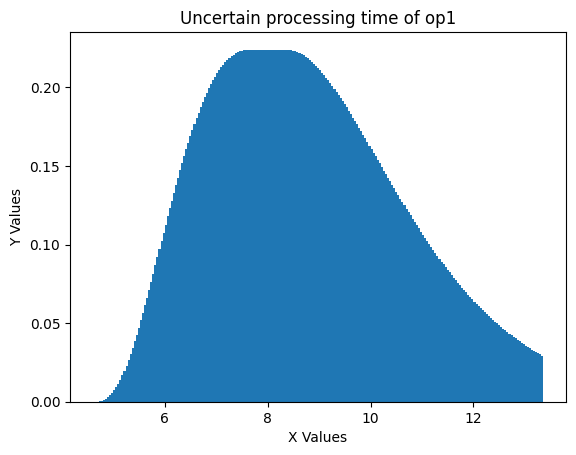

op1_start: 0
op1_mean: 9.0
op2_start: 10
worst case: 13
critical: 5
p: 0.2650259152973615


In [756]:
x_values = np.arange(op1["min_time"], worst_case_x, step)
y_values = [gamma.pdf(x-op1["min_time"], shape, scale=scale) for x in x_values]
plt.bar(x_values, y_values)
plt.xlabel('X Values')
plt.ylabel('Y Values')
plt.title('Uncertain processing time of op1')
plt.show()

print(f"op1_start: {op1['start']}")
print(f"op1_mean: {op1['mean_time']}")
print(f"op2_start: {op2_start}")
print(f"worst case: {worst_case_x}")
print(f"critical: {critical_x}")
print(f"p: {p}")